In [2]:
mp_pdf = False
import django, sys, os
if mp_pdf:
    import matplotlib
    matplotlib.use('pgf')
    pgf_with_latex = {
        "text.usetex": True,            # use LaTeX to write all text
        "pgf.rcfonts": False,           # Ignore Matplotlibrc
        "text.latex.unicode": True,
        "pgf.preamble": [
            #r"\usepackage[utf8x]{inputenc}",
            r"\usepackage{xcolor}"
        ],
        "pgf.texsystem" : "xelatex",
        "figure.figsize": [12,7]
    }
    matplotlib.rcParams.update(pgf_with_latex)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle
%matplotlib notebook

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
from django.db.models import Q, F, Sum, Count, FloatField, Case, When, Value, Max
from scipy.sparse import coo_matrix, find
from sklearn.manifold import TSNE

from scoping.models import *
from tmv_app.models import *
import tmv_app.utils.plotting as tplots
from time import time
from matplotlib import patches

run_id = 1013
s = 0
p = 50

run_id=665
p = 200



In [3]:
class SquareCollection:
    def __init__(self):
        self.objects = []
        
    def add(self, o):
        self.objects.append(o)

    def get(self,**kwargs):
        matches = []
        for o in self.objects:
            match = True
            for k,v in kwargs.items():
                if getattr(o,k)!=v:
                    match=False
            if match:
                matches.append(o)
        if len(matches) > 0:
            return matches[0]
        else:
            return None
                
class CoordSquare:
    def __init__(self,x1,x2,y1,y2,r_ind,tsne_results,ar=None):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.r_ind = r_ind
        self.tsne_results = tsne_results
        self.ar = ar
        self.size = self.r_ind.shape[0]
        self.share = None
    
    def get_points(self):
        r = self.tsne_results#[self.r_ind[:,0],:]
        conditions = (r[:,0]>self.x1) & (r[:,0]<self.x2) & (r[:,1]>self.y1) & (r[:,1]<self.y2)
        self.r = r[conditions]
        self.r_ind = self.r_ind[conditions]
        
        self.share = self.r.shape[0] / self.size
        
        return self.r.shape[0] / self.size
    def summarise_topics(self,run_id):
        stat = RunStats.objects.get(pk=run_id)
        docs = Doc.objects.filter(id__in=self.r_ind)
        if stat.method=="DT":
            dt_string = 'docdynamictopic'
        else:
            dt_string = 'doctopic'
        topics = docs.filter(
            **{f'{dt_string}__run_id': run_id}
        ).values(f'{dt_string}__topic__title').annotate(
            tscore=Sum(f'{dt_string}__score')
        ).order_by('-tscore')
        total = topics.aggregate(tsum = Sum('tscore'))
        df = pd.DataFrame.from_dict(list(topics))
        df['x1'] = self.x1
        df['x2'] = self.x2
        df['y1'] = self.y1
        df['y2'] = self.y2
        df['proportion'] = df['tscore'] / total['tsum']
        df = df[df['proportion']>0.001]
        return df

In [4]:
m = np.load('../tsne_results/data/run_{}_s_{}_m.npy'.format(run_id,s))
r_ind = np.load('../tsne_results/data/run_{}_s_{}_r_ind.npy'.format(run_id,s))
tsne_results = np.load('../tsne_results/data/run_{}_s_{}_p{}.npy'.format(run_id,s,p))

In [5]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
no_oecd_ids = r_ind
oecd_cats = list(Doc.objects.filter(id__in=r_ind).distinct('wc__oecd').values('wc__oecd'))
for i,c in enumerate(oecd_cats):
    c['docs'] = list(Doc.objects.filter(id__in=r_ind,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
    c['name'] = c['wc__oecd']
    c['color'] = colors[i]
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_oecd_ids = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]


calculating points took 1.242s.
[-20. -15. -10.  -5.   0.   5.  10.  15.  20.]


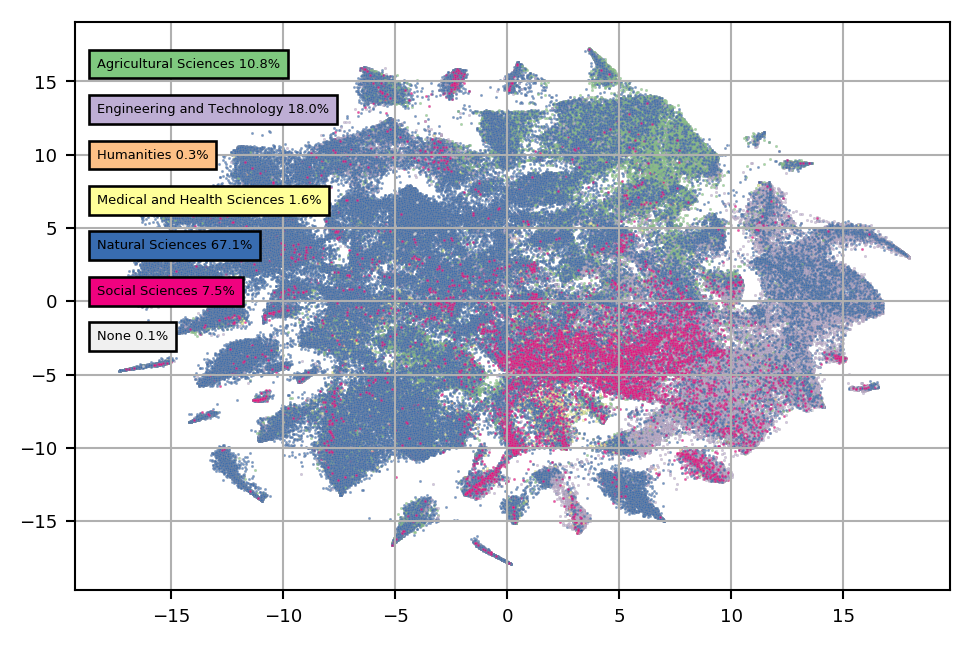

In [6]:
import importlib
importlib.reload(tmv_app.utils.plotting)

tplots.plot_tsne(r_ind,tsne_results,oecd_cats,no_oecd_ids,verbose=True)
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_oecds.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_oecds.png'.format(run_id,s,p))

sc = SquareCollection()   
xs = plt.xticks()[0]
ys = plt.yticks()[0]

print(xs)

for i, x1 in enumerate(xs):
    if i==len(xs)-1:
        break
    x2 = xs[i+1]
    for j, y1 in enumerate(ys):
        if j==len(ys)-1:
            break
        y2 = ys[j+1]

        cs = CoordSquare(x1,x2,y1,y2,r_ind,tsne_results,0)
        cs.get_points()
        sc.add(cs)
    
#plt.show()

In [7]:
df = None
for cs in sc.objects:
    if cs.share > 0:
        topics = cs.summarise_topics(run_id)
        if df is None:
            df = topics
        else:
            df = df.append(topics)
df.to_csv(f"../tables/tsne_topic_index_{run_id}.csv")

In [8]:
df

,docdynamictopic__topic__title,tscore,x1,x2,y1,y2,proportion
0,"{ozon, stratospher, tropospher}",169.152741,-20.0,-15.0,-5.0,0.0,0.440205
1,"{increas, concentr, decreas}",13.280526,-20.0,-15.0,-5.0,0.0,0.034561
2,"{climat, chang, impact}",12.686680,-20.0,-15.0,-5.0,0.0,0.033016
3,"{emiss, reduct, reduc}",10.309311,-20.0,-15.0,-5.0,0.0,0.026829
4,"{aerosol, cloud, radiat}",9.849981,-20.0,-15.0,-5.0,0.0,0.025634
5,"{atmospher, surfac, observ}",8.903616,-20.0,-15.0,-5.0,0.0,0.023171
6,"{trend, station, signific}",7.601754,-20.0,-15.0,-5.0,0.0,0.019783
7,"{model, simul, predict}",7.342472,-20.0,-15.0,-5.0,0.0,0.019108
8,"{temperatur, air, mean}",7.203397,-20.0,-15.0,-5.0,0.0,0.018746
9,"{sst, pacif, atlant}",6.374167,-20.0,-15.0,-5.0,0.0,0.016588


In [9]:
colors=["#66c2a5","#fc8d62","#8da0cb"]

no_wg_ids = r_ind
wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
for i,c in enumerate(wgs):
    c['docs'] = list(Doc.objects.filter(
        id__in=r_ind,ipccref__wg__wg=c['wg']
    ).values_list('id',flat=True))
    c['color'] = colors[i]
    c['name'] = "WG{}".format(c['wg'])
    c["dis"] = np.argwhere(np.isin(r_ind,c['docs']))
    no_wg_ids = no_wg_ids[np.isin(no_wg_ids,c['docs'],invert=True)]
    


calculating points took 1.082s.


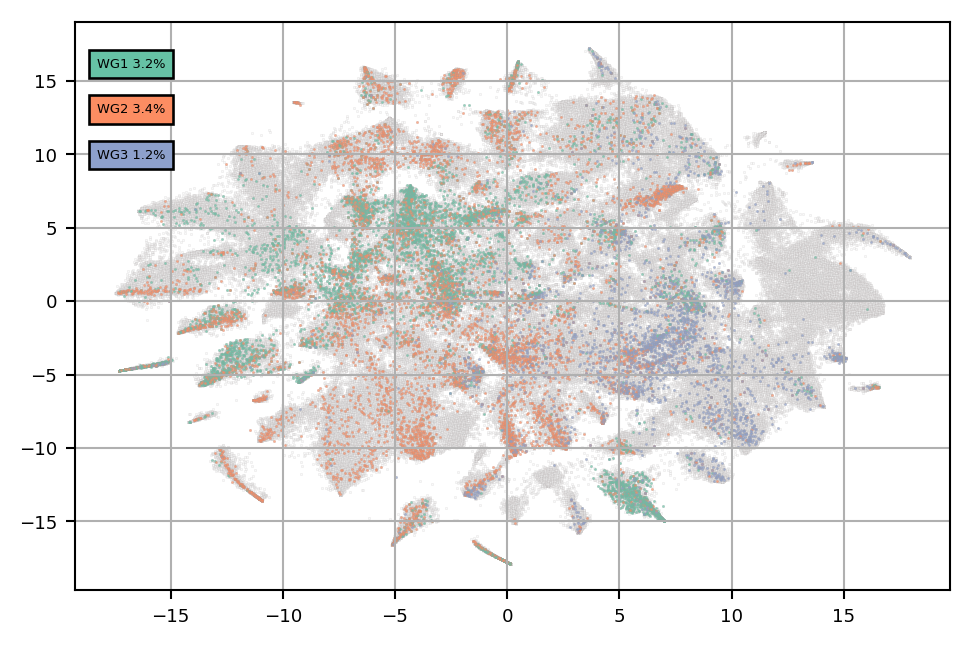

In [10]:
import importlib
importlib.reload(tmv_app.utils.plotting)

tmv_app.utils.plotting.plot_tsne(r_ind,tsne_results,wgs,no_wg_ids,verbose=True)

if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_wgs.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_wgs.png'.format(run_id,s,p))


plt.show()

calculating points took 1.104s.


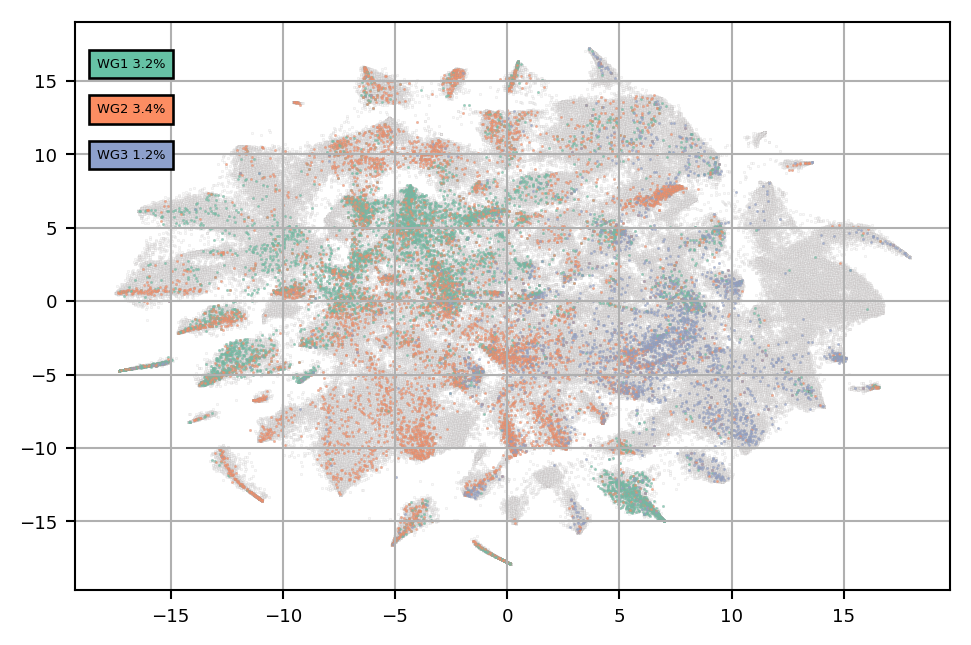

In [11]:
import importlib
importlib.reload(tmv_app.utils.plotting)

highlight_doc = np.argwhere(r_ind==69164)[0]

tmv_app.utils.plotting.plot_tsne(r_ind,tsne_results,wgs,no_wg_ids,verbose=True, hdoc=highlight_doc)

calculating points took 1.189s.


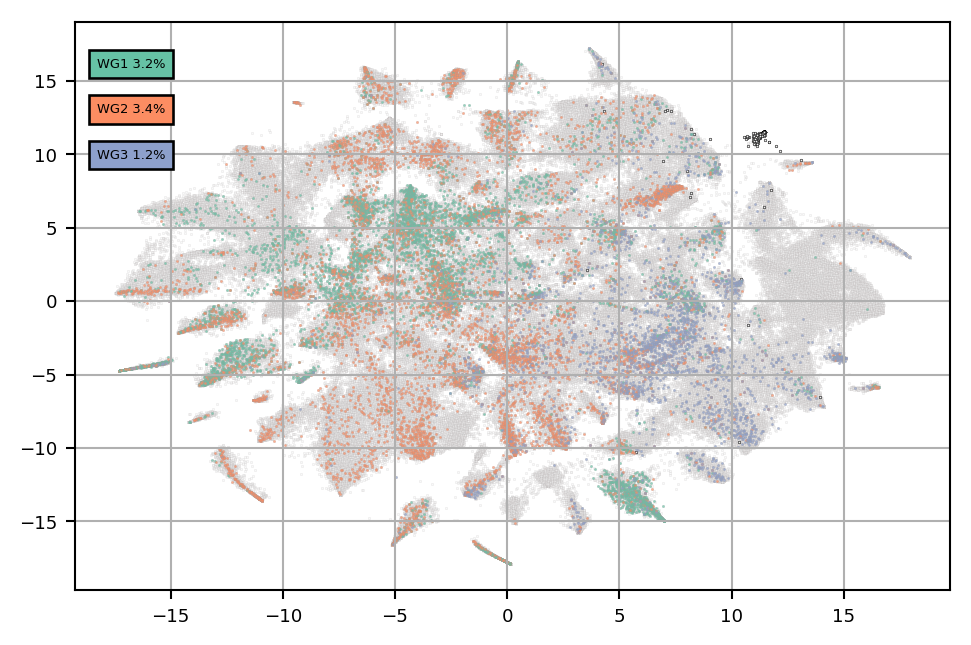

In [12]:
import importlib
importlib.reload(tmv_app.utils.plotting)

impacts = 11110
research = 11046
tech_ccs = 11026
biochar = 11020
aerosols = 11059

top = DynamicTopic.objects.get(pk=biochar)
tdocs = Doc.objects.filter(
    docdynamictopic__topic=top,
    docdynamictopic__score__gt=0.06
).order_by('-docdynamictopic__score').values_list('id',flat=True)

highlight_docs = np.argwhere(np.isin(r_ind,tdocs))

tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,wgs,
    no_wg_ids,verbose=True, hdoc=highlight_docs
)

calculating points took 1.069s.
calculating points took 1.124s.


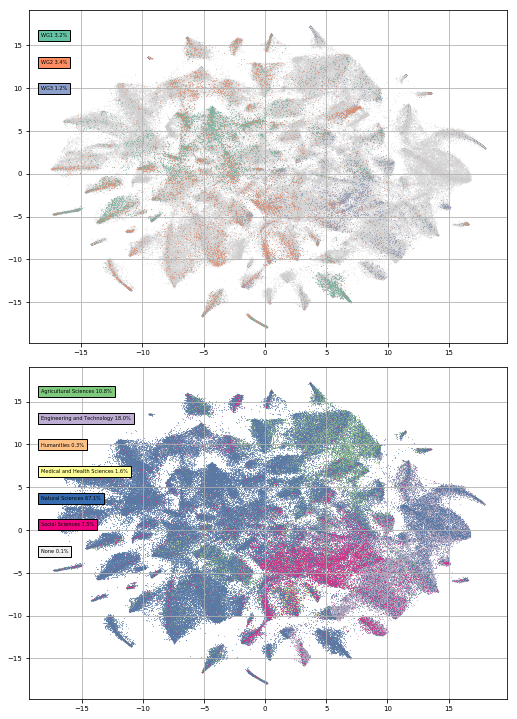

In [13]:
fig, axs = plt.subplots(2,1,figsize=(7.2,10))
tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,wgs,
    no_wg_ids,axs[0],verbose=True
)

tmv_app.utils.plotting.plot_tsne(
    r_ind,tsne_results,oecd_cats,
    no_oecd_ids,axs[1],verbose=True
)

fig.tight_layout()
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_double.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_double.png'.format(run_id,s,p))

plt.show()

In [14]:
xlim = axs[1].get_xlim()
ylim = axs[1].get_ylim()

117
calculating points took 0.031s.
5930
calculating points took 0.053s.
14619
calculating points took 0.086s.
31457
calculating points took 0.155s.
110104
calculating points took 0.501s.
124526
calculating points took 0.666s.


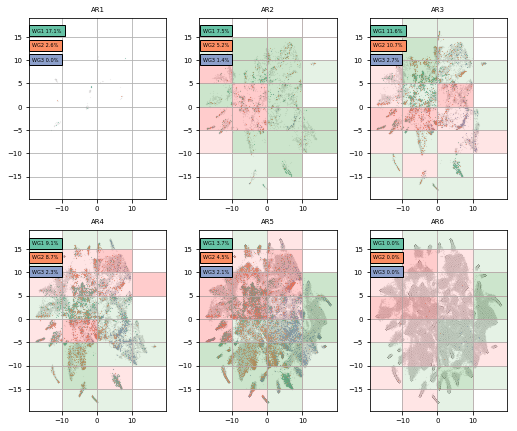

In [15]:

fig = plt.figure(figsize=(7.2,6))

sc = SquareCollection()   

for i,ar in enumerate(AR.objects.filter(ar__gt=0).order_by('ar')):
    ax = fig.add_subplot(2,3,i+1)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    ys = range(ar.start,ar.end+1)
    ydocs = Doc.objects.filter(id__in=r_ind,PY__in=ys).values_list('pk',flat=True)  
    
    print(len(ydocs))
    
    doc_matches = np.argwhere(np.isin(r_ind,ydocs))[:,0]
    doc_ids = r_ind[doc_matches]
    results = tsne_results[doc_matches]

    
    colors=["#66c2a5","#fc8d62","#8da0cb"]

    no_wg_ids = doc_ids
    wgs = list(scoping.models.WG.objects.all().distinct('wg').values('wg'))
    for i,c in enumerate(wgs):
        c['docs'] = list(Doc.objects.filter(
            id__in=doc_ids,ipccref__wg__wg=c['wg']
        ).values_list('id',flat=True))
        c['color'] = colors[i]
        c['name'] = "WG{}".format(c['wg'])
        c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
        no_wg_ids = no_wg_ids[np.isin(no_wg_ids,c['docs'],invert=True)]
        
    colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f','#F0F0F0']
        
    no_oecd_ids = doc_ids
    oecd_cats = list(Doc.objects.filter(id__in=doc_ids).distinct('wc__oecd').values('wc__oecd'))
    for i,c in enumerate(oecd_cats):
        c['docs'] = list(Doc.objects.filter(id__in=doc_ids,wc__oecd=c['wc__oecd']).values_list('id',flat=True))
        c['name'] = c['wc__oecd']
        c['color'] = colors[i]
        c["dis"] = np.argwhere(np.isin(doc_ids,c['docs']))
        no_oecd_ids = no_oecd_ids[np.isin(no_oecd_ids,c['docs'],invert=True)]

    #tmv_app.utils.plotting.plot_tsne(
    #    doc_ids,results,oecd_cats,
    #    no_oecd_ids,ax,verbose=True,
    #    legend=False
    #)
    tmv_app.utils.plotting.plot_tsne(
        doc_ids,results,wgs,
        no_wg_ids,ax,verbose=True
    )
    ax.set_title(ar.name)
    
    xs = ax.get_xticks()
    ys = ax.get_yticks()
         

    for i, x1 in enumerate(xs):
        if i==len(xs)-1:
            break
        x2 = xs[i+1]
        for j, y1 in enumerate(ys):
            if j==len(ys)-1:
                break
            y2 = ys[j+1]

            cs = CoordSquare(x1,x2,y1,y2,doc_ids,results,ar.ar)
            cs.get_points()
            sc.add(cs)
            prev = sc.get(x1=x1,x2=x2,y1=y1,y2=y2,ar=ar.ar-1)
            
            if prev is not None:        
                if cs.share > prev.share:
                    col = "green"
                elif cs.share == prev.share:
                    col = "None"
                else:
                    col = "red"
                    
                if abs(cs.share-prev.share) > 0.01:
                    alpha = 0.2
                else:
                    alpha = 0.1

                # Create a Rectangle patch
                rect = patches.Rectangle(
                    (x1,y1),x2-x1,y2-y1,
                    linewidth=1,edgecolor='r',
                    facecolor=col,alpha=alpha
                )

                # Add the patch to the Axes
                ax.add_patch(rect)
                
            #ax.text(
            #    x2-(x2-x1)/2,y2-(y2-y1)/2,"bla",
            #    ha="center",
            #    va="center"
            #)



fig.tight_layout()
if mp_pdf:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_evolution.pdf'.format(run_id,s,p))
else:
    plt.savefig('../tsne_results/plots/run_{}_s_{}_p{}_evolution.png'.format(run_id,s,p))
plt.show()

In [16]:
topics.head()

,docdynamictopic__topic__title,tscore,x1,x2,y1,y2,proportion
0,"{inject, storag, reservoir}",5.700354,15.0,20.0,5.0,10.0,0.258490
1,"{uncertainti, estim, method}",1.635409,15.0,20.0,5.0,10.0,0.074160
2,"{groundwat, runoff, hydrolog}",1.221700,15.0,20.0,5.0,10.0,0.055400
3,"{water, resourc, suppli}",1.071986,15.0,20.0,5.0,10.0,0.048611
4,"{data, use, method}",0.836975,15.0,20.0,5.0,10.0,0.037954


In [17]:
cs.r_ind
self = cs
r = self.tsne_results
print(r.shape)
conditions = (r[:,0]>self.x1) & (r[:,0]<self.x2) & (r[:,1]>self.y1) & (r[:,1]<self.y2)
r[conditions].shape

(124526, 2)


(0, 2)

In [18]:
class SquareCollection:
    def __init__(self):
        self.objects = []
        
    def add(self, o):
        self.objects.append(o)

    def get(self,**kwargs):
        matches = []
        for o in self.objects:
            match = True
            for k,v in kwargs.items():
                if getattr(o,k)!=v:
                    match=False
            if match:
                matches.append(o)
        if len(matches) > 0:
            return matches[0]
        else:
            return None
                
class CoordSquare:
    def __init__(self,x1,x2,y1,y2,r_ind,tsne_results,ar=None):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
        self.r_ind = r_ind
        self.tsne_results = tsne_results
        self.ar = ar
        self.size = self.r_ind.shape[0]
        self.share = None
    
    def get_points(self):
        r = self.tsne_results#[self.r_ind[:,0],:]
        conditions = (r[:,0]>self.x1) & (r[:,0]<self.x2) & (r[:,1]>self.y1) & (r[:,1]<self.y2)
        self.r = r[conditions]
        
        self.share = self.r.shape[0] / self.size
        
        return self.r.shape[0] / self.size
    
sc = SquareCollection()        

for i, x1 in enumerate(xs):
    if i==len(xs)-1:
        break
    x2 = xs[i+1]
    for j, y1 in enumerate(ys):
        if j==len(ys-1):
            break
        y2 = ys[i+1]
        
        cs = CoordSquare(x1,x2,y1,y2,doc_ids,tsne_results)
        sc.add(cs)
               
        
    if x1 > 5 and y1 > 5:
        break
        
        

In [19]:
import networkx as nx
import pickle
import random
G = nx.read_gpickle("/tmp/bibCouple_q_2355.pickle")
with open("/tmp/docnet_dict_q_2355.pickle", "rb") as f:
    m_dict = pickle.load(f)
with open("/tmp/docnet_revdict_q_2355.pickle", "rb") as f:
    rev_m_dict = pickle.load(f)

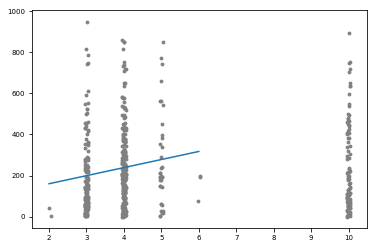

In [29]:
def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)]) 

def get_doc():
    for i in range(25):
        x = random.randint(0,len(m_dict))
        x_did = rev_m_dict[x]
        try:
            x_ind = np.argwhere(np.isin(r_ind,x_did))[:,0][0]
            x_doc = Doc.objects.get(pk=x_did)
            tsne = tsne_results[x_ind]
            break
        except:
            pass
    return x, x_did, x_ind, x_doc, tsne

X = []
Y = []

for i in range(500):  
    x, x_ind, x_did, x_doc, x_tsne = get_doc()       
    y, y_ind, y_did, y_doc, y_tsne = get_doc()

    #print(x_doc.title)
    #print(y_doc.title)

    distance = square_distance(x_tsne,y_tsne)

    try:
        path = len(nx.shortest_path(G,x,y))
        X.append(path)
        Y.append(distance)
    except:
        path = 10
        

    plt.scatter(path + random.random()*0.1-0.05, distance, s = 8, c = "grey")



plt.plot(np.unique(X), np.poly1d(np.polyfit(X, Y, 1))(np.unique(X)))


In [27]:
len(X)

500

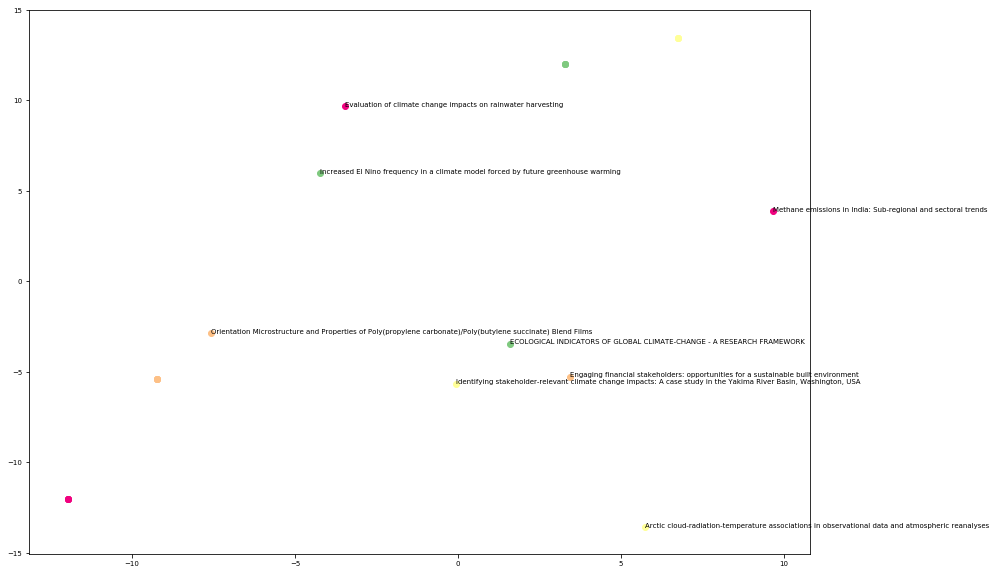

In [21]:
fig = plt.figure(figsize=(7.2,5))
fig = plt.figure(figsize=(14,10))
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
for i in range(6):  
    x, x_ind, x_did, x_doc, x_tsne = get_doc()       
    y, y_ind, y_did, y_doc, y_tsne = get_doc()

    #print(x_doc.title)
    #print(y_doc.title)

    distance = square_distance(x_tsne,y_tsne)

    try:
        path = nx.shortest_path(G,x,y)
    except:
        continue
        
    plt.scatter(x_tsne[0],x_tsne[1], c=colors[i])
    plt.text(x_tsne[0],x_tsne[1],x_doc.title)
    
    plt.scatter(y_tsne[0],y_tsne[1], c=colors[i])
    plt.text(y_tsne[0],y_tsne[1],y_doc.title)
    
    for j in path:
        j_did = rev_m_dict[j]
        j_ind = np.argwhere(np.isin(r_ind,j_did))[:,0][0]
        j_doc = Doc.objects.get(pk=j_did)
        tsne = tsne_results[x_ind]
        plt.scatter(tsne[0],tsne[1], c=colors[i])
        #plt.text(y_tsne[0],y_tsne[1],y_doc.title)

In [22]:
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99','#386cb0','#f0027f']
for i in range(8):  
    x, x_ind, x_did, x_doc, x_tsne = get_doc()       
    y, y_ind, y_did, y_doc, y_tsne = get_doc()

    #print(x_doc.title)
    #print(y_doc.title)

    distance = square_distance(x_tsne,y_tsne)

    try:
        path = nx.shortest_path(G,x,y)
    except:
        continue
        
    print("\n############")
    print(f"T-sne distance {distance}")
    print(f"{x_doc.title}")
    
    for j in path[1:-1]:
        j_did = rev_m_dict[j]
        try:
            j_ind = np.argwhere(np.isin(r_ind,j_did))[:,0][0]
        except:
            pass
        j_doc = Doc.objects.get(pk=j_did)
        print(f" - via - {j_doc.title}")
        tsne = tsne_results[x_ind]
        #plt.scatter(tsne[0],tsne[1], c=colors[i])
        #plt.text(y_tsne[0],y_tsne[1],y_doc.title)
    print(y_doc.title)


############
T-sne distance 150.39147055141666
Place as a boundary device for the sustainability sciences: Concepts of place, their value in characterising sustainability problems, and their role in fostering integrative research and action
 - via - The Contributions of Regional Knowledge Networks Researching Environmental Changes in Latin America and Africa: a Synthesis of what they can do and why they can be policy relevant
Policy review: thoughts on addressing population and climate change in a just and ethical manner

############
T-sne distance 452.5809292255875
Why do consumers respond to eco-labels? The case of Korea
 - via - The Role of Emotion in Global Warming Policy Support and Opposition
 - via - Environmental Tipping Points
 - via - The sensitivity of the Australian summer monsoon to climate forcing during the late Quaternary
Late Quaternary alluviation along intermittent streams in Kakadu National Park, Northern Territory

############
T-sne distance 80.0481912148943
Ene

## Report topic composition of each square..... give in SM

##  furthest and closest points



def square_distance(x,y): return sum([(xi-yi)**2 for xi, yi in zip(x,y)])    

square_distance(tsne_results[0],tsne_results[1])
ma = 0
mi = 100
for i in range(len(tsne_results)):
    for j in range(len(tsne_results)):
        if i != j:
            d = square_distance(tsne_results[i],tsne_results[j])
            if d < mi:
                mi = d
                p1mi = i
                p2mi = j
            if d > ma:
                ma = d
                p1ma = i
                p1mi = j
        

from scipy.spatial import cKDTree
from scipy.spatial.distance import pdist, squareform
import timeit

Y = pdist(tsne_results[:10000])

Y.shape

m = squareform(Y)

m.shape

outside_points = tsne_results[(abs(tsne_results[:,0])>10) & (abs(tsne_results[:,1])>10)]

Y = pdist(outside_points)

m = squareform(Y)

m[2167,2168]